In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [27]:
START_DATE = '2016-01-01'
END_DATE = '2024-5-29'
ASSET = ['AAPL','TSLA', 'MSFT',"NVDA","GOOGL","AMZN","META"]
prices_df = yf.download(ASSET,start = START_DATE,end = END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df.head()


[*********************100%%**********************]  7 of 7 completed

Downloaded 2114 rows of data.


Price       Adj Close                                                         \
Ticker           AAPL       AMZN      GOOGL        META       MSFT      NVDA   
Date                                                                           
2016-01-04  23.914482  31.849501  37.972000  102.111656  48.521465  7.899908   
2016-01-05  23.315193  31.689501  38.076500  102.621124  48.742832  8.026814   
2016-01-06  22.858932  31.632500  37.966499  102.860863  47.857410  7.694903   
2016-01-07  21.894180  30.396999  37.049999   97.816216  46.192795  7.389843   
2016-01-08  22.009947  30.352501  36.545502   97.226845  46.334480  7.231209   

Price                      Close                        ...       Open  \
Ticker           TSLA       AAPL       AMZN      GOOGL  ...       MSFT   
Date                                                    ...              
2016-01-04  14.894000  26.337500  31.849501  37.972000  ...  54.320000   
2016-01-05  14.895333  25.677500  31.689501  38.076500  ...  54.930000   
2016-01-06  14.602667  25.174999  31.632500  37.966499  ...  54.320000   
2016-01-07  14.376667  24.112499  30.396999  37.049999  ...  52.700001   
2016-01-08  14.066667  24.240000  30.352501  36.545502  ...  52.369999   

Price                             Volume                                 \
Ticker        NVDA       TSLA       AAPL       AMZN     GOOGL      META   
Date                                                                      
2016-01-04  8.0725  15.381333  270597600  186290000  67382000  37912400   
2016-01-05  8.2450  15.090667  223164000  116452000  45216000  23258200   
2016-01-06  8.0875  14.666667  273829600  106584000  48206000  25096200   
2016-01-07  7.6850  14.279333  324377600  141498000  63132000  45172900   
2016-01-08  7.6675  14.524000  283192000  110258000  47506000  35402300   

Price                                      
Ticker          MSFT      NVDA       TSLA  
Date                                       
2016-01-04  53778000  35807600  102406500  
2016-01-05  34079700  49027200   47802000  
2016-01-06  39518900  44934400   56686500  
2016-01-07  56564900  64530400   53314500  
2016-01-08  48754000  39847200   54421500  

[5 rows x 42 columns]

In [28]:
big_7_returns = prices_df['Adj Close'].pct_change().dropna()

aapl_returns = big_7_returns['AAPL']
aapl_returns.head()

Date
2016-01-05   -0.025060
2016-01-06   -0.019569
2016-01-07   -0.042205
2016-01-08    0.005288
2016-01-11    0.016192
Name: AAPL, dtype: float64

In [29]:
model_arima = pm.auto_arima(aapl_returns, start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False, d=0,
                            trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
fc_arima, confint_arima = model_arima.predict(n_periods=len(data) + 12 * 4, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10910.861, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10903.541, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10912.835, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10912.861, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-10910.856, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10908.825, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10920.676, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10909.860, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10918.752, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-10918.721, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10920.519, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-10916.683, Time=0.26 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.455 seconds


E:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
E:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
model_sarimax = SARIMAX(aapl_returns, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
results_sarimax = model_sarimax.fit()
fc_sarimax = results_sarimax.forecast(steps=len(data) + 12 * 4)

E:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_m

In [32]:
mse_arima = mean_squared_error(aapl_returns, fc_arima[:len(aapl_returns)])
mse_sarimax = mean_squared_error(aapl_returns, fc_sarimax[:len(aapl_returns)])
print(f'MSE for ARIMA: {mse_arima}')
print(f'MSE for SARIMAX: {mse_sarimax}')

MSE for ARIMA: 0.000334464890749331
MSE for SARIMAX: 0.0003366041356236223


In [33]:
if mse_arima < mse_sarimax:
    selected_model = model_arima
    fc_selected = fc_arima
else:
    selected_model = model_sarimax
    fc_selected = fc_sarimax

In [37]:
fc_final, confint_final = selected_model.predict(n_periods=12 * 10, return_conf_int=True)
future_dates = pd.date_range(start=END_DATE, periods=12 * 10, freq='M')

E:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
E:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


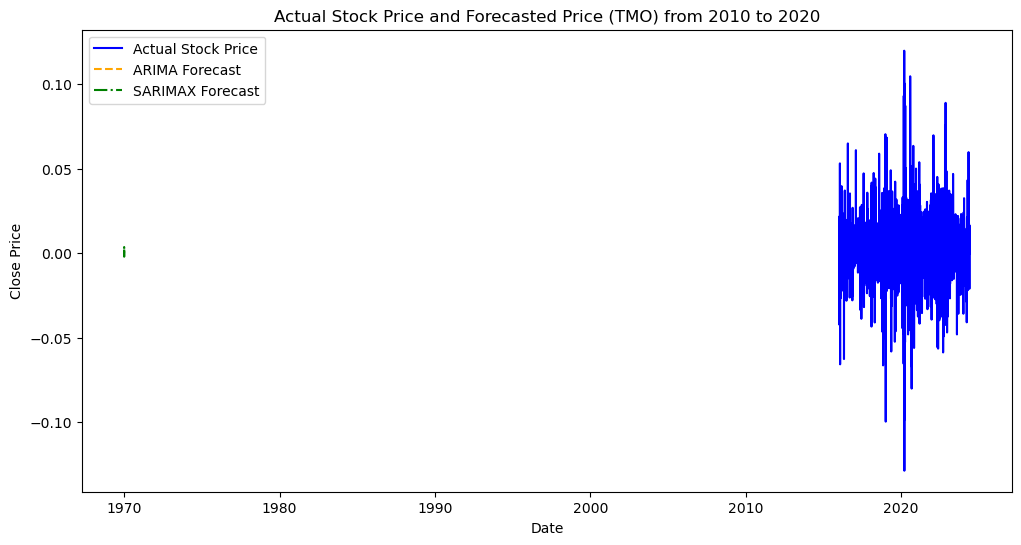

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(aapl_returns, label='Actual Stock Price', color='blue')
plt.plot(aapl_returns, fc_arima[:len(aapl_returns)], label='ARIMA Forecast', color='orange', linestyle='--')
plt.plot(aapl_returns, fc_sarimax[:len(aapl_returns)], label='SARIMAX Forecast', color='green', linestyle='-.')
plt.title(f'Actual Stock Price and Forecasted Price ({ticker}) from 2010 to 2020')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

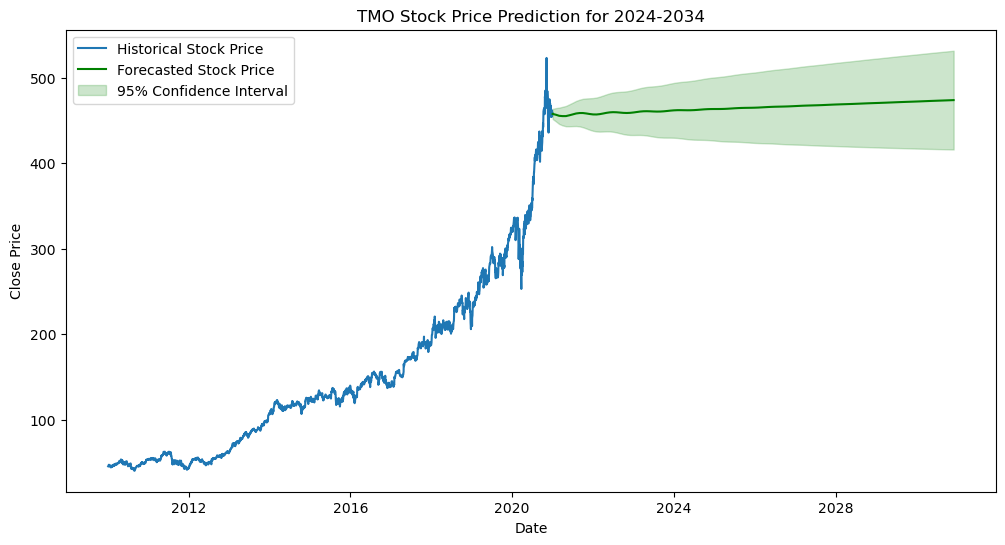

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Historical Stock Price')
plt.plot(future_dates, fc_final, label='Forecasted Stock Price', color='green')
plt.fill_between(future_dates, confint_final[:, 0], confint_final[:, 1], alpha=0.2, color='green', label='95% Confidence Interval')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction for 2024-2034')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()